In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from math import sqrt
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
import glob

sns.set_style('white')

In [2]:
filename_2019 = glob.glob('../data/2019/*.csv')
filename_2019

['../data/2019/jmm.csv',
 '../data/2019/jm.csv',
 '../data/2019/egm.csv',
 '../data/2019/lm.csv',
 '../data/2019/cum.csv',
 '../data/2019/hcm.csv',
 '../data/2019/rbm.csv',
 '../data/2019/smm.csv',
 '../data/2019/im.csv',
 '../data/2019/ppm.csv',
 '../data/2019/alm.csv',
 '../data/2019/nim.csv',
 '../data/2019/cfm.csv',
 '../data/2019/tam.csv',
 '../data/2019/pbm.csv',
 '../data/2019/znm.csv',
 '../data/2019/mam.csv',
 '../data/2019/ebm.csv',
 '../data/2019/agm.csv',
 '../data/2019/srm.csv',
 '../data/2019/vm.csv',
 '../data/2019/snm.csv',
 '../data/2019/oim.csv',
 '../data/2019/rum.csv',
 '../data/2019/bum.csv']

In [3]:
df = pd.read_csv(filename_2019[0], index_col=0, encoding='gbk')
df.columns = ['code', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'open interest']
df.rename_axis("type", axis='index', inplace=True)
df['time'] = pd.to_datetime(df['time'])

df.reset_index(inplace=True)
df

,type,code,time,open,high,low,close,volume,turnover,open interest
0,DC,jm1905,2019-01-02 09:01:00,1171.0,1176.0,1169.0,1172.5,4228.0,297235260.0,212034
1,DC,jm1905,2019-01-02 09:02:00,1172.5,1176.5,1172.5,1174.0,1828.0,128881500.0,211456
2,DC,jm1905,2019-01-02 09:03:00,1174.0,1176.5,1174.0,1175.5,1482.0,104521260.0,211368
3,DC,jm1905,2019-01-02 09:04:00,1175.5,1176.0,1173.0,1174.0,850.0,59894700.0,211380
4,DC,jm1905,2019-01-02 09:05:00,1174.0,1175.0,1174.0,1174.0,590.0,41572980.0,211252
...,...,...,...,...,...,...,...,...,...,...
85015,DC,jm2005,2019-12-31 14:56:00,1163.5,1165.5,1162.5,1165.5,1746.0,121952160.0,155608
85016,DC,jm2005,2019-12-31 14:57:00,1165.0,1165.5,1164.5,1165.5,614.0,42924960.0,155662
85017,DC,jm2005,2019-12-31 14:58:00,1165.0,1166.0,1165.0,1165.0,630.0,44048940.0,155544
85018,DC,jm2005,2019-12-31 14:59:00,1165.5,1166.0,1165.0,1165.5,538.0,37614480.0,155648


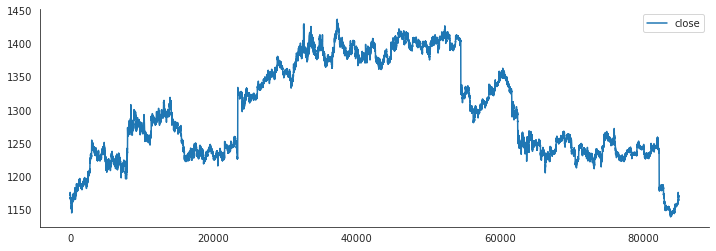

In [4]:
df[['close']].plot(grid=False, figsize=(12,4))
sns.despine()

In [5]:
df['one_minute_return'] = df['close'].shift(-1) - df['close']
df['five_minute_return'] = df['close'].shift(-5) - df['close']
df['fifteen_minute_return'] = df['close'].shift(-15) - df['close']
df['thirty_minute_return'] = df['close'].shift(-30) - df['close']
df['hour_return'] = df['close'].shift(-60) - df['close']

In [6]:
times = ['one_minute_return','five_minute_return', 'fifteen_minute_return', 'thirty_minute_return', 'hour_return']

In [7]:
# Drop NaN
df.drop(df.tail(60).index,inplace=True) 

In [8]:
df['one_minute_return']

0        1.5
1        1.5
2       -1.5
3        0.0
4       -2.5
        ... 
84955    0.0
84956    0.0
84957   -0.5
84958    0.0
84959   -1.0
Name: one_minute_return, Length: 84960, dtype: float64

In [9]:
short_period = [2, 4, 8, 16, 32, 64]
long_period = [8, 16, 32, 64, 128, 256]

df['short_ewm'] = df['close'].ewm(span=short_period[2]).mean()
df['long_ewm'] = df['close'].ewm(span=long_period[2]).mean()

In [10]:
def calculate_hull_moving_average(df, period):

    df['window_t_ewm'] = df['close'].ewm(span=period).mean()
    df['window_half_ewm'] = df['close'].ewm(span=period/2).mean()
    df['diff']=df['window_half_ewm'] * 2 - df['window_t_ewm']
    
    df[f'hma{period}']=df['diff'].ewm(span=int(math.sqrt(period))).mean()
    
    irrelevant_col = ['window_t_ewm', 'window_half_ewm', 'diff']
    df.drop(columns=irrelevant_col, inplace = True)
    
calculate_hull_moving_average(df, short_period[2])
calculate_hull_moving_average(df, long_period[2])

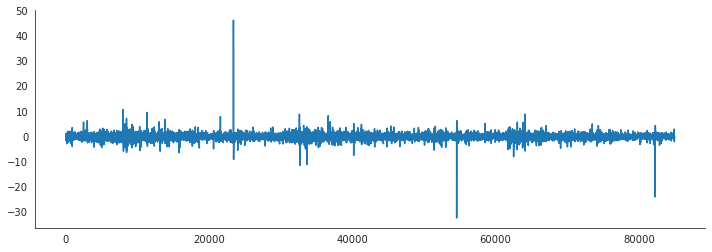

In [11]:
df['short_long_diff'] = df[f'hma{short_period[2]}'] - df[f'hma{long_period[2]}']

short_long_diff_std = df['short_long_diff'].std()

df['momentum'] = df['short_long_diff'] / short_long_diff_std

df['momentum'].plot(grid=False, figsize=(12,4))
sns.despine()

In [12]:
X2 = sm.add_constant(df['momentum'])
est = sm.OLS(df['one_minute_return'], X2, missing='drop')
results = est.fit()
print(results.summary())
print("Parameters: ", results.params['momentum'])
print("P Values: ", results.pvalues)

                            OLS Regression Results                            
Dep. Variable:      one_minute_return   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     140.1
Date:                Mon, 05 Apr 2021   Prob (F-statistic):           2.69e-32
Time:                        17:02:49   Log-Likelihood:            -1.2132e+05
No. Observations:               84960   AIC:                         2.426e+05
Df Residuals:                   84958   BIC:                         2.427e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.718e-05      0.003     -0.011      0.9

In [13]:
threshold = [0, 0.1, 0.25, 0.5, 0.75, 1, 2]

In [14]:
def calculate_future_return(data):
    data['one_minute_return'] = data['close'].shift(-1) - data['close']
    data['five_minute_return'] = data['close'].shift(-5) - data['close']
    data['fifteen_minute_return'] = data['close'].shift(-15) - data['close']
    data['thirty_minute_return'] = data['close'].shift(-30) - data['close']
    data['hour_return'] = data['close'].shift(-60) - data['close']
    # Drop NaN
    df.drop(df.tail(60).index,inplace=True) 

In [15]:
def calculate_momentum(data, short_period, long_period, hma=True):
    if (hma):
        calculate_hull_moving_average(data, short_period)
        calculate_hull_moving_average(data, long_period)
        data['short_long_diff'] = data[f'hma{short_period}'] - data[f'hma{long_period}']
        short_long_diff_std = data['short_long_diff'].std()
        data['momentum'] = data['short_long_diff'] / short_long_diff_std
        
        used_col = ['short_long_diff', f'hma{short_period}', f'hma{long_period}']
        data.drop(columns=used_col, inplace = True)
        
    else:
        data['short_ewm'] = data['close'].ewm(span=short_period).mean()
        data['long_ewm'] = data['close'].ewm(span=long_period).mean()
        data['short_long_diff'] = data['short_ewm'] - data['long_ewm']
        short_long_diff_std = data['short_long_diff'].std()
        data['momentum'] = data['short_long_diff'] / short_long_diff_std
        
        used_col = ['short_long_diff', data['short_ewm'], data['short_ewm']]
        data.drop(columns=used_col, inplace = True)

In [16]:
def linear_regression_parameters_of_momentum(data, time = 'one_minute_return'):
    X2 = sm.add_constant(data['momentum'])
    est = sm.OLS(data[time], X2, missing='drop')
    results = est.fit()
    # print(results.summary())
    parameter = results.params['momentum']
    r_square = results.rsquared
    
    return parameter, r_square

沪银主力（AGM），表格Index为均线Window长度（short-long），Column为Return Time Window

In [25]:
# data = pd.read_csv(filename_2019[0], index_col=0, encoding='gbk')
# data = pd.read_csv('../data/2019/agm.csv', index_col=0, encoding='gbk')

data.columns = ['code', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'open interest']
data.rename_axis("type", axis='index', inplace=True)
data['time'] = pd.to_datetime(data['time'])

data.reset_index(inplace=True)
calculate_future_return(data)

In [26]:
parameters = []
r_squares = []
for i in range(len(short_period)):
    calculate_momentum(data, short_period[i], long_period[i])
    current_window_parameter = []
    current_window_r_square = []
    for j in range(len(times)):
        sum_return, sharpe = linear_regression_parameters_of_momentum(data, times[j])
        current_window_parameter.append(sum_return)
        current_window_r_square.append(sharpe)
    parameters.append(current_window_parameter)
    r_squares.append(current_window_r_square)

In [27]:
# parameters
parameters_df = pd.DataFrame.from_records(parameters, index =['2-8','4-16','8-32','16-64', '32-128', '64-256'])
parameters_df.columns = times
print('Regression Parameter')
parameters_df

Regression Parameter


,one_minute_return,five_minute_return,fifteen_minute_return,thirty_minute_return,hour_return
2-8,-0.105370,-0.203153,-0.239384,-0.206108,-0.210832
4-16,-0.084907,-0.228265,-0.222060,-0.157874,-0.196999
8-32,-0.062569,-0.163538,-0.090759,-0.034309,-0.127927
16-64,-0.024131,-0.043580,0.044677,0.023419,-0.115471
32-128,-0.007336,-0.004399,0.028562,-0.034357,-0.083459
64-256,0.000260,0.010184,0.030719,0.030911,0.158997


In [28]:
# r_squares
r_squares_df = pd.DataFrame.from_records(r_squares, index =['2-8','4-16','8-32','16-64', '32-128', '64-256'])
r_squares_df.columns = times
print('R-Squared')
r_squares_df

R-Squared


,one_minute_return,five_minute_return,fifteen_minute_return,thirty_minute_return,hour_return
2-8,4.466649e-03,0.003851,0.001967,0.000735,0.000388
4-16,2.900277e-03,0.004862,0.001693,0.000431,0.000339
8-32,1.574927e-03,0.002496,0.000283,0.000020,0.000143
16-64,2.342620e-04,0.000177,0.000069,0.000009,0.000116
32-128,2.165320e-05,0.000002,0.000028,0.000020,0.000061
64-256,2.714756e-08,0.000010,0.000032,0.000017,0.000221
